In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pypfopt import (
    CLA,
    BlackLittermanModel,
    EfficientFrontier,
    HRPOpt,
    black_litterman,
    expected_returns,
    #plotting,
    risk_models,
)

In [37]:
"""
The ``plotting`` module houses all the functions to generate various plots.

Currently implemented:

  - ``plot_covariance`` - plot a correlation matrix
  - ``plot_dendrogram`` - plot the hierarchical clusters in a portfolio
  - ``plot_efficient_frontier`` – plot the efficient frontier from an EfficientFrontier or CLA object
  - ``plot_weights`` - bar chart of weights
"""
import warnings

import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as sch

from pypfopt import CLA, EfficientFrontier, exceptions, risk_models

try:
    plt.style.use("seaborn-deep")
except Exception:  # pragma: no cover
    pass


def _plot_io(**kwargs):
    """
    Helper method to optionally save the figure to file.

    :param filename: name of the file to save to, defaults to None (doesn't save)
    :type filename: str, optional
    :param dpi: dpi of figure to save or plot, defaults to 300
    :type dpi: int (between 50-500)
    :param showfig: whether to plt.show() the figure, defaults to False
    :type showfig: bool, optional
    """
    filename = kwargs.get("filename", None)
    showfig = kwargs.get("showfig", False)
    dpi = kwargs.get("dpi", 300)

    plt.tight_layout()
    if filename:
        plt.savefig(fname=filename, dpi=dpi)
    if showfig:  # pragma: no cover
        plt.show()


def plot_covariance(cov_matrix, plot_correlation=False, show_tickers=True, **kwargs):
    """
    Generate a basic plot of the covariance (or correlation) matrix, given a
    covariance matrix.

    :param cov_matrix: covariance matrix
    :type cov_matrix: pd.DataFrame or np.ndarray
    :param plot_correlation: whether to plot the correlation matrix instead, defaults to False.
    :type plot_correlation: bool, optional
    :param show_tickers: whether to use tickers as labels (not recommended for large portfolios),
                        defaults to True
    :type show_tickers: bool, optional

    :return: matplotlib axis
    :rtype: matplotlib.axes object
    """
    if plot_correlation:
        matrix = risk_models.cov_to_corr(cov_matrix)
    else:
        matrix = cov_matrix
    fig, ax = plt.subplots()

    cax = ax.imshow(matrix)
    fig.colorbar(cax)

    if show_tickers:
        ax.set_xticks(np.arange(0, matrix.shape[0], 1))
        ax.set_xticklabels(matrix.index)
        ax.set_yticks(np.arange(0, matrix.shape[0], 1))
        ax.set_yticklabels(matrix.index)
        plt.xticks(rotation=90)

    _plot_io(**kwargs)

    return ax


def plot_dendrogram(hrp, ax=None, show_tickers=True, **kwargs):
    """
    Plot the clusters in the form of a dendrogram.

    :param hrp: HRPpt object that has already been optimized.
    :type hrp: object
    :param show_tickers: whether to use tickers as labels (not recommended for large portfolios),
                        defaults to True
    :type show_tickers: bool, optional
    :param filename: name of the file to save to, defaults to None (doesn't save)
    :type filename: str, optional
    :param showfig: whether to plt.show() the figure, defaults to False
    :type showfig: bool, optional
    :return: matplotlib axis
    :rtype: matplotlib.axes object
    """
    ax = ax or plt.gca()

    if hrp.clusters is None:
        warnings.warn(
            "hrp param has not been optimized. Attempting optimization.",
            RuntimeWarning,
        )
        hrp.optimize()

    if show_tickers:
        sch.dendrogram(hrp.clusters, labels=hrp.tickers, ax=ax, orientation="top")
        ax.tick_params(axis="x", rotation=90)
        plt.tight_layout()
    else:
        sch.dendrogram(hrp.clusters, no_labels=True, ax=ax)

    _plot_io(**kwargs)

    return ax


def _plot_cla(cla, points, ax, show_assets, show_tickers):
    """
    Helper function to plot the efficient frontier from a CLA object
    """
    if cla.weights is None:
        cla.max_sharpe()
    optimal_ret, optimal_risk, _ = cla.portfolio_performance()

    if cla.frontier_values is None:
        cla.efficient_frontier(points=points)

    mus, sigmas, _ = cla.frontier_values

    ax.plot(sigmas, mus, label="Efficient frontier")
    ax.scatter(optimal_risk, optimal_ret, marker="x", s=100, color="r", label="optimal")

    asset_mu = cla.expected_returns
    asset_sigma = np.sqrt(np.diag(cla.cov_matrix))
    if show_assets:
        ax.scatter(
            asset_sigma,
            asset_mu,
            s=30,
            color="k",
            label="assets",
        )
        if show_tickers:
            for i, label in enumerate(cla.tickers):
                ax.annotate(label, (asset_sigma[i], asset_mu[i]))
    return ax


def _ef_default_returns_range(ef, points):
    """
    Helper function to generate a range of returns from the GMV returns to
    the maximum (constrained) returns
    """
    ef_minvol = ef.deepcopy()
    ef_maxret = ef.deepcopy()

    ef_minvol.min_volatility()
    min_ret = ef_minvol.portfolio_performance()[0]
    max_ret = ef_maxret._max_return()
    return np.linspace(min_ret, max_ret - 0.0001, points)


def _plot_ef(ef, ef_param, ef_param_range, ax, show_assets, show_tickers):
    """
    Helper function to plot the efficient frontier from an EfficientFrontier object
    """
    mus, sigmas = [], []

    # Create a portfolio for each value of ef_param_range
    for param_value in ef_param_range:
        try:
            if ef_param == "utility":
                ef.max_quadratic_utility(param_value)
            elif ef_param == "risk":
                ef.efficient_risk(param_value)
            elif ef_param == "return":
                ef.efficient_return(param_value)
            else:
                raise NotImplementedError(
                    "ef_param should be one of {'utility', 'risk', 'return'}"
                )
        except exceptions.OptimizationError:
            continue
        except ValueError:
            warnings.warn(
                "Could not construct portfolio for parameter value {:.3f}".format(
                    param_value
                )
            )

        ret, sigma, _ = ef.portfolio_performance()
        mus.append(ret)
        sigmas.append(sigma)

    ax.plot(sigmas, mus, label="Efficient frontier")

    asset_mu = ef.expected_returns
    asset_sigma = np.sqrt(np.diag(ef.cov_matrix))
    if show_assets:
        ax.scatter(
            asset_sigma,
            asset_mu,
            s=30,
            color="k",
            label="assets",
        )
        if show_tickers:
            for i, label in enumerate(ef.tickers):
                ax.annotate(label, (asset_sigma[i], asset_mu[i]))
    return ax


def plot_efficient_frontier(
    opt,
    ef_param="return",
    ef_param_range=None,
    points=100,
    ax=None,
    show_assets=True,
    show_tickers=False,
    **kwargs
):
    """
    Plot the efficient frontier based on either a CLA or EfficientFrontier object.

    :param opt: an instantiated optimizer object BEFORE optimising an objective
    :type opt: EfficientFrontier or CLA
    :param ef_param: [EfficientFrontier] whether to use a range over utility, risk, or return.
                     Defaults to "return".
    :type ef_param: str, one of {"utility", "risk", "return"}.
    :param ef_param_range: the range of parameter values for ef_param.
                           If None, automatically compute a range from min->max return.
    :type ef_param_range: np.array or list (recommended to use np.arange or np.linspace)
    :param points: number of points to plot, defaults to 100. This is overridden if
                   an `ef_param_range` is provided explicitly.
    :type points: int, optional
    :param show_assets: whether we should plot the asset risks/returns also, defaults to True
    :type show_assets: bool, optional
    :param show_tickers: whether we should annotate each asset with its ticker, defaults to False
    :type show_tickers: bool, optional
    :param filename: name of the file to save to, defaults to None (doesn't save)
    :type filename: str, optional
    :param showfig: whether to plt.show() the figure, defaults to False
    :type showfig: bool, optional
    :return: matplotlib axis
    :rtype: matplotlib.axes object
    """
    ax = ax or plt.gca()

    if isinstance(opt, CLA):
        ax = _plot_cla(
            opt, points, ax=ax, show_assets=show_assets, show_tickers=show_tickers
        )
    elif isinstance(opt, EfficientFrontier):
        if ef_param_range is None:
            ef_param_range = _ef_default_returns_range(opt, points)

        ax = _plot_ef(
            opt,
            ef_param,
            ef_param_range,
            ax=ax,
            show_assets=show_assets,
            show_tickers=show_tickers,
        )
    else:
        raise NotImplementedError("Please pass EfficientFrontier or CLA object")

    ax.legend()
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Return")

    _plot_io(**kwargs)
    return ax


def plot_weights(weights, ax=None, **kwargs):
    """
    Plot the portfolio weights as a horizontal bar chart

    :param weights: the weights outputted by any PyPortfolioOpt optimizer
    :type weights: {ticker: weight} dict
    :param ax: ax to plot to, optional
    :type ax: matplotlib.axes
    :return: matplotlib axis
    :rtype: matplotlib.axes
    """
    ax = ax or plt.gca()

    desc = sorted(weights.items(), key=lambda x: x[1], reverse=True)
    labels = [i[0] for i in desc]
    vals = [i[1] for i in desc]

    y_pos = np.arange(len(labels))

    ax.barh(y_pos, vals)
    ax.set_xlabel("Weight")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()

    _plot_io(**kwargs)
    return ax

In [2]:
df = pd.read_csv('./data/stock_prices.csv')

In [3]:
df.head()

,date,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT,BAC,...,T,UAA,SHLD,XOM,RRC,BBY,MA,PFE,JPM,SBUX
0,1989-12-29,NaN,0.117203,NaN,NaN,NaN,0.352438,3.9375,3.486070,1.752478,...,2.365775,NaN,NaN,1.766756,NaN,0.166287,NaN,0.110818,1.827968,NaN
1,1990-01-02,NaN,0.123853,NaN,NaN,NaN,0.364733,4.1250,3.660858,1.766686,...,2.398184,NaN,NaN,1.766756,NaN,0.173216,NaN,0.113209,1.835617,NaN
2,1990-01-03,NaN,0.124684,NaN,NaN,NaN,0.364050,4.0000,3.660858,1.780897,...,2.356516,NaN,NaN,1.749088,NaN,0.194001,NaN,0.113608,1.896803,NaN
3,1990-01-04,NaN,0.125100,NaN,NaN,NaN,0.362001,3.9375,3.641439,1.743005,...,2.403821,NaN,NaN,1.731422,NaN,0.190537,NaN,0.115402,1.904452,NaN
4,1990-01-05,NaN,0.125516,NaN,NaN,NaN,0.358586,3.8125,3.602595,1.705114,...,2.287973,NaN,NaN,1.722587,NaN,0.190537,NaN,0.114405,1.912100,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7126 entries, 0 to 7125
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    7126 non-null   object 
 1   GOOG    3435 non-null   float64
 2   AAPL    7126 non-null   float64
 3   FB      1483 non-null   float64
 4   BABA    896 non-null    float64
 5   AMZN    5261 non-null   float64
 6   GE      7126 non-null   float64
 7   AMD     7126 non-null   float64
 8   WMT     7126 non-null   float64
 9   BAC     7126 non-null   float64
 10  GM      1860 non-null   float64
 11  T       7126 non-null   float64
 12  UAA     3118 non-null   float64
 13  SHLD    3763 non-null   float64
 14  XOM     7126 non-null   float64
 15  RRC     6369 non-null   float64
 16  BBY     7126 non-null   float64
 17  MA      2990 non-null   float64
 18  PFE     7126 non-null   float64
 19  JPM     7126 non-null   float64
 20  SBUX    6496 non-null   float64
dtypes: float64(20), object(1)
memory usag

In [5]:
df_assets = df.select_dtypes(include='float')
mu = expected_returns.mean_historical_return(df_assets)
S = risk_models.CovarianceShrinkage(df_assets)

In [6]:
risk = S.shrunk_covariance()

In [24]:
risk.describe()

,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT,BAC,GM,T,UAA,SHLD,XOM,RRC,BBY,MA,PFE,JPM,SBUX
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.033488,0.040436,0.022793,0.023122,0.057055,0.034432,0.058832,0.022585,0.051229,0.026320,0.022109,0.052919,0.049584,0.023525,0.040251,0.045158,0.041045,0.024383,0.047200,0.037760
std,0.019930,0.040344,0.029694,0.022993,0.067552,0.019129,0.069827,0.017318,0.035684,0.018822,0.016403,0.044505,0.058811,0.014380,0.051043,0.050484,0.024911,0.019217,0.030778,0.030389
min,0.013828,0.015979,0.004866,0.005763,0.020156,0.011832,0.021562,0.004866,0.018355,0.011109,0.005458,0.022363,0.008751,0.008700,0.010841,0.014065,0.018181,0.009996,0.014845,0.013942
25%,0.023472,0.018779,0.010710,0.013738,0.028819,0.023381,0.032858,0.013800,0.027939,0.017537,0.016879,0.029733,0.024295,0.017328,0.021828,0.022787,0.024937,0.017789,0.028144,0.019694
50%,0.028889,0.034443,0.015879,0.019252,0.042708,0.030567,0.045101,0.021555,0.042015,0.021353,0.018745,0.046578,0.037591,0.021144,0.029762,0.034475,0.037392,0.019254,0.039251,0.032806
75%,0.037878,0.037785,0.022853,0.022731,0.054760,0.039837,0.055194,0.024015,0.056273,0.030341,0.023420,0.054103,0.051265,0.024814,0.039831,0.047093,0.044863,0.025545,0.056078,0.040753
max,0.109080,0.200541,0.144272,0.115278,0.334826,0.100998,0.346980,0.089785,0.178665,0.098604,0.086959,0.230930,0.291441,0.078034,0.252295,0.250150,0.130754,0.102912,0.152025,0.156582


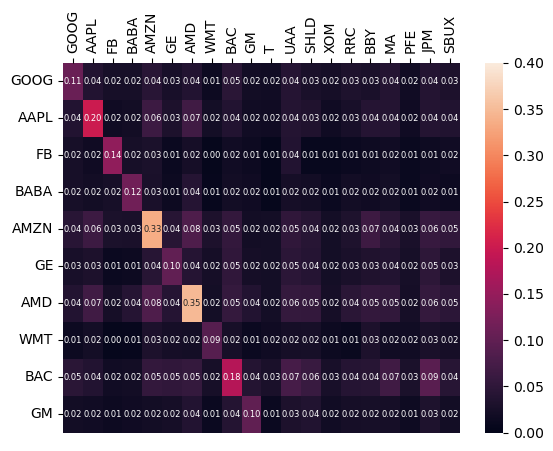

In [25]:
ax = sns.heatmap(risk[:10], annot=True,fmt = '.2f',
            annot_kws={"size": 6},
            vmin=0.0, vmax=0.4)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [27]:
from pypfopt.efficient_frontier import EfficientFrontier
ef = EfficientFrontier(mu, risk)
weights = ef.max_sharpe()

In [29]:
ef.portfolio_performance(verbose = True)

Expected annual return: 29.7%
Annual volatility: 20.9%
Sharpe Ratio: 1.33


(0.29725208275397125, 0.20902574870093818, 1.3264015772078266)

In [32]:
from pypfopt import objective_functions
ef = EfficientFrontier(mu, risk)
ef.add_objective(objective_functions.L2_reg, gamma = 0.1)
w = ef.max_sharpe()
print(ef.clean_weights())

OrderedDict([('GOOG', 0.08964), ('AAPL', 0.09152), ('FB', 0.15472), ('BABA', 0.0794), ('AMZN', 0.07761), ('GE', 0.0), ('AMD', 0.0), ('WMT', 0.01945), ('BAC', 0.0), ('GM', 0.0), ('T', 0.0), ('UAA', 0.0), ('SHLD', 0.0), ('XOM', 0.03749), ('RRC', 0.0), ('BBY', 0.0447), ('MA', 0.22156), ('PFE', 0.12495), ('JPM', 0.0), ('SBUX', 0.05895)])


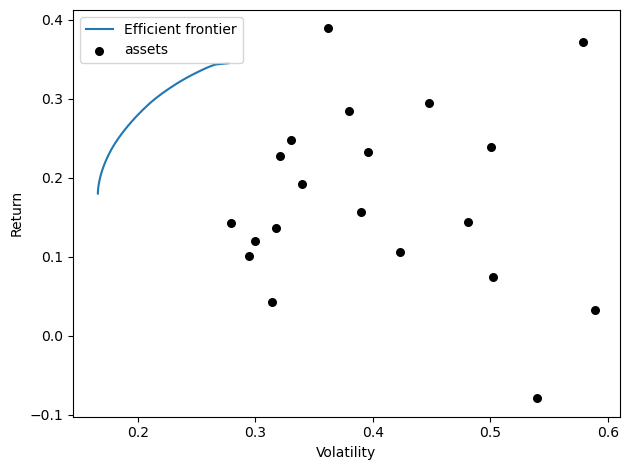

In [45]:
ef = EfficientFrontier(mu, risk)
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

c:\Users\jpaul\miniconda3\envs\myenv\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


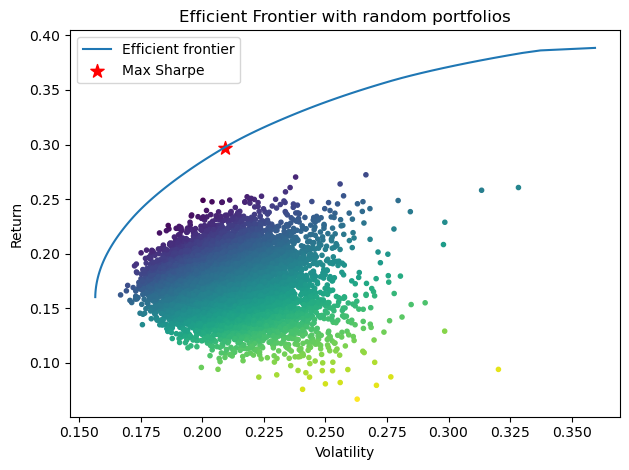

In [53]:
ef = EfficientFrontier(mu, risk)
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

<Axes: xlabel='Weight'>

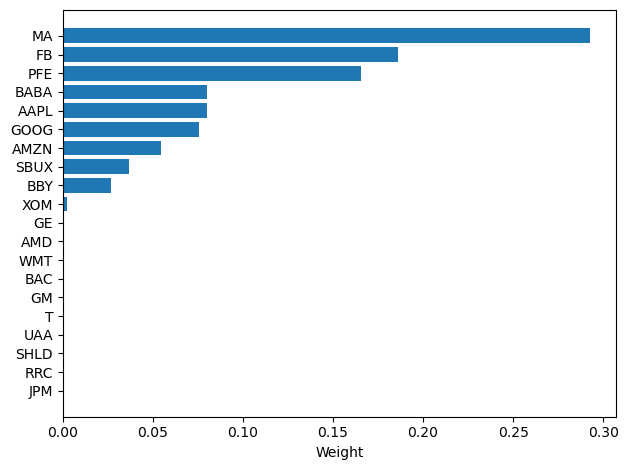

In [55]:
plot_weights(weights)

In [56]:
np.random.seed(1)
n = 10
mu = np.abs(np.random.randn(n, 1))
Sigma = np.random.randn(n,n)
Sigma = Sigma.T.dot(Sigma)

In [61]:
import cvxpy as cp 

w = cp.Variable(n)
gamma = cp.Parameter(nonneg = True)
ret = mu.T@w
risk = cp.quad_form(w, Sigma)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), [cp.sum(w)==1, w >= 0])

In [68]:
# Compute trade-off curve
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num = SAMPLES)

for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = cp.sqrt(risk).value
    ret_data[i] = ret.value

C:\Users\jpaul\AppData\Local\Temp\ipykernel_13692\2113018989.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret_data[i] = ret.value


Text(0, 0.5, 'Return')

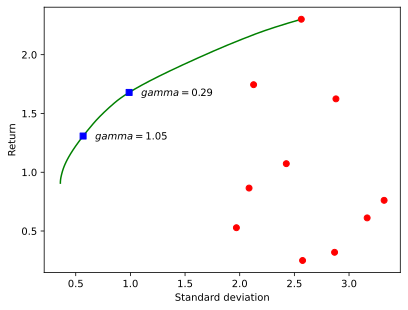

In [69]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [29,40]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, "g-")
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], "bs")
    ax.annotate(
        r"$\ gamma = %.2f$" %gamma_vals[marker],
        xy = (risk_data[marker] + 0.08, ret_data[marker] - 0.03),
    )

for i in range(n):
    plt.plot(cp.sqrt(Sigma[i,i]).value, mu[i], "ro")

plt.xlabel("Standard deviation")
plt.ylabel("Return")

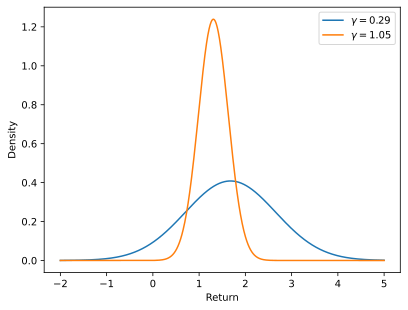

In [71]:
# Plot return distributions for two points on trade-off curve
import scipy.stats as spstats

plt.figure()
for midx, idx in enumerate(markers_on):
    gamma.value = gamma_vals[idx]
    prob.solve()
    x = np.linspace(-2, 5, 1000)
    plt.plot(
        x,
        spstats.norm.pdf(x, ret.value, risk.value),
        label = r"$\gamma = %.2f$" %gamma.value,
    )
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend(loc = "upper right")
plt.show()

#### Portfolio constraints

In [72]:
# Portfolio optimization with leverage limit
Lmax = cp.Parameter()
prob = cp.Problem(
    cp.Maximize(ret - gamma*risk),
    [cp.sum(w) == 1, cp.norm(w, 1)<=Lmax]
)

In [11]:
import yfinance as yf

def get_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

# Replace 'PETR4.SA' with the stock symbol of the company you are interested in
# Replace '2023-01-01' and '2023-12-31' with your desired start and end dates
#stock_symbol = 'PETR4.SA'
stock_symbol = 'ABEV3.SA'
start_date = '2023-01-01'
end_date = '2023-12-31'

stock_values = get_stock_data(stock_symbol, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [127]:
# Define the symbol for the Bovespa index
bovespa_index_symbol = '^BVSP'

# Get historical components of the Bovespa index
bovespa_history = yf.Ticker(bovespa_index_symbol)

In [155]:
# Import the necessary modules
import pandas as pd
import yfinance as yf


def get_sp_data(start='2020-01-01', end= '2023-12-31'):
    data = {}
    # Get the current SP components, and get a tickers list
    sp_assets = pd.read_html(
        'https://pt.wikipedia.org/wiki/Lista_de_companhias_citadas_no_Ibovespa')[0]
    assets = sp_assets['Código'].str.replace('.', '-').tolist()
    assets = [f"{x}.SA" for x in assets]
    # Download historical data to a multi-index DataFrame
    try:
        data = yf.download(assets, start=start, end=end)
        filename = 'sp_components_data.pkl'
        data.to_pickle(filename)
        print('Data saved at {}'.format(filename))
    except ValueError:
        print('Failed download, try again.')
        data = None
    return data


data = get_sp_data()

[*********************100%%**********************]  76 of 76 completed


12 Failed downloads:
['VVAR3.SA', 'BRML3.SA', 'LAME4.SA', 'HGTX3.SA', 'BRDT3.SA', 'GNDI3.SA', 'TIMP3.SA', 'ENBR3.SA', 'BTOW3.SA', 'IGTA3.SA', 'VIVT4.SA', 'SULA11.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')



Data saved at sp_components_data.pkl


In [160]:
df = data[['Adj Close']].reset_index()

In [161]:
nomes_colunas = [x[0] if x[0] == 'Date' else x[1].replace('.SA','') for x in df.columns]

In [162]:
df.columns = nomes_colunas

In [131]:
acoes_avaliadas = ['ABEV3','AZUL4','BBDC4','VALE3','BBAS3','CSAN3']

In [184]:
df_assets = df.select_dtypes('float')
df_assets.dropna(axis = 1, inplace= True)
returns = df_assets.pct_change().dropna(how = 'all')

In [186]:
import cvxpy as cp
from timeit import default_timer as timer

# Definição dos inputs iniciais
mu = returns.mean().to_numpy().reshape(1,-1)
sigma = returns.cov().to_numpy()

# Criação das Variáveis
x = cp.Variable((mu.shape[1],1))

# Definição das restrições
restricoes = [cp.sum(x) == 1,
              x <= 1,
              x >= 0]

# Definição da função objetivo
risk = cp.quad_form(x, sigma)
objective = cp.Minimize(risk)

weights = pd.DataFrame([])
# Solving the problem with several solvers
prob = cp.Problem(objective, restricoes)

In [187]:
prob.solve()

0.00014593906957135322

In [190]:
x.value

array([[ 4.68159469e-02],
       [ 5.58381141e-19],
       [-1.06582330e-19],
       [-5.46909593e-20],
       [-9.31556542e-20],
       [-5.26158851e-21],
       [ 1.85787578e-01],
       [ 2.42672195e-02],
       [ 1.36060480e-02],
       [ 2.83244169e-19],
       [-4.95282371e-19],
       [-5.28342186e-19],
       [-6.63536306e-19],
       [-1.42477881e-19],
       [-1.03586071e-18],
       [-2.91618052e-19],
       [-1.30452075e-18],
       [ 7.84418167e-03],
       [-2.34239787e-19],
       [ 3.42103300e-19],
       [ 4.62584723e-20],
       [-4.09624339e-19],
       [-7.87682585e-19],
       [ 3.79466071e-01],
       [-7.81447584e-19],
       [-8.28546096e-19],
       [ 7.42473731e-19],
       [-1.43060347e-18],
       [-3.62286352e-19],
       [ 3.10434715e-19],
       [ 2.37308072e-19],
       [ 1.03088170e-18],
       [ 2.40942945e-19],
       [-2.05694823e-19],
       [ 6.52086156e-20],
       [-1.43622847e-19],
       [ 7.45170945e-20],
       [-5.75753383e-19],
       [-3.8

In [193]:
x.value.shape

(59, 1)

In [ ]:
len(acoes_avaliadas)

In [198]:
pd.DataFrame(x.value, index=df_assets.columns.tolist()).sort_values(by = 0,ascending=False)

,0
EGIE3,3.794661e-01
SUZB3,1.952078e-01
BBSE3,1.857876e-01
RADL3,1.234196e-01
ABEV3,4.681595e-02
BEEF3,2.426722e-02
VALE3,1.820899e-02
BRAP4,1.360605e-02
CRFB3,7.844182e-03
PCAR3,5.376525e-03


In [69]:
df_assets = df.select_dtypes(include='float')
mu = expected_returns.mean_historical_return(df_assets)
S = risk_models.CovarianceShrinkage(df_assets)

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BRAP4,BRFS3,...,RAIL3,RENT3,SBSP3,SUZB3,TOTS3,UGPA3,USIM5,VALE3,WEGE3,YDUQ3
ABEV3,0.102719,0.119626,0.061913,0.064359,0.065310,0.066678,0.038516,0.039322,0.030876,0.068971,...,0.029167,0.038713,0.023928,0.015027,0.026491,0.015772,0.026352,0.024004,0.019287,0.034075
AZUL4,0.119626,0.661954,0.194066,0.176689,0.167607,0.173548,0.085642,0.095708,0.079684,0.189092,...,0.087924,0.133244,0.058787,0.045797,0.105766,0.062044,0.092722,0.064775,0.087677,0.124594
B3SA3,0.061913,0.194066,0.195734,0.101745,0.098018,0.097391,0.060309,0.055298,0.060833,0.096916,...,0.043086,0.045781,0.026603,0.016491,0.044184,0.018603,0.040515,0.037750,0.034841,0.045970
BBAS3,0.064359,0.176689,0.101745,0.164415,0.122652,0.124113,0.065380,0.049482,0.058244,0.083312,...,0.038346,0.052771,0.039256,0.019818,0.051058,0.024365,0.050620,0.040967,0.031241,0.052104
BBDC3,0.065310,0.167607,0.098018,0.122652,0.142330,0.144422,0.057113,0.040628,0.062361,0.082324,...,0.034211,0.042989,0.037684,0.021679,0.042507,0.021277,0.045323,0.037800,0.028852,0.050959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UGPA3,0.015772,0.062044,0.018603,0.024365,0.021277,0.019309,0.009788,0.011130,0.003771,0.019152,...,0.068482,0.106372,0.072069,0.018750,0.080617,0.171579,0.079468,0.036845,0.047420,0.116791
USIM5,0.026352,0.092722,0.040515,0.050620,0.045323,0.040695,0.028960,0.025182,0.064381,0.040208,...,0.078594,0.118898,0.082417,0.065761,0.090312,0.079468,0.294694,0.137836,0.065837,0.128654
VALE3,0.024004,0.064775,0.037750,0.040967,0.037800,0.034703,0.025514,0.034285,0.073970,0.043317,...,0.053326,0.066292,0.047931,0.050268,0.053489,0.036845,0.137836,0.163800,0.037856,0.061719
WEGE3,0.019287,0.087677,0.034841,0.031241,0.028852,0.028145,0.014948,0.021076,0.023659,0.029894,...,0.066278,0.091485,0.047493,0.045445,0.090318,0.047420,0.065837,0.037856,0.161901,0.086971


In [75]:
df_assets.cov()*1/252

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BRAP4,BRFS3,...,RAIL3,RENT3,SBSP3,SUZB3,TOTS3,UGPA3,USIM5,VALE3,WEGE3,YDUQ3
ABEV3,0.008714,0.029260,-0.000152,0.012973,0.006680,0.008714,0.003193,0.000591,0.018775,0.007023,...,0.000894,0.031085,-0.002213,0.017001,0.016321,0.002612,0.011518,0.054350,0.012651,0.001139
AZUL4,0.029260,0.611859,0.057754,-0.127165,0.089682,0.095282,-0.118630,-0.038344,0.179998,0.294704,...,0.024029,0.086807,-0.123502,0.168042,0.064963,0.115944,0.152506,0.258084,-0.020275,0.410445
B3SA3,-0.000152,0.057754,0.021496,-0.014920,0.009003,0.008311,-0.009582,-0.003805,0.025364,0.025171,...,0.009582,0.029685,0.005573,0.024745,0.007640,0.023896,0.014705,0.030575,0.016292,0.053598
BBAS3,0.012973,-0.127165,-0.014920,0.262878,-0.005878,-0.008323,0.139639,0.008656,-0.066070,-0.120997,...,0.033543,0.108937,0.204997,-0.063698,0.006024,0.027185,-0.070648,-0.103797,0.037401,-0.095190
BBDC3,0.006680,0.089682,0.009003,-0.005878,0.016884,0.018913,-0.013058,-0.002744,0.024219,0.043150,...,0.005555,0.024054,-0.007414,0.022313,0.010845,0.018194,0.021465,0.041533,-0.007515,0.059200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UGPA3,0.002612,0.115944,0.023896,0.027185,0.018194,0.014817,0.005765,-0.013633,0.025305,0.047183,...,0.025662,0.036896,0.043400,0.024520,0.003405,0.059595,0.013637,-0.006206,0.005896,0.110239
USIM5,0.011518,0.152506,0.014705,-0.070648,0.021465,0.028612,-0.059121,-0.012262,0.104545,0.075048,...,-0.011043,0.059877,-0.105757,0.124201,0.052185,0.013637,0.083588,0.255507,0.031727,0.058970
VALE3,0.054350,0.258084,0.030575,-0.103797,0.041533,0.070373,-0.070604,-0.009261,0.427666,0.052321,...,-0.052756,0.338935,-0.272235,0.492503,0.229649,-0.006206,0.255507,1.296341,0.237670,-0.100707
WEGE3,0.012651,-0.020275,0.016292,0.037401,-0.007515,-0.005822,0.032580,-0.005954,0.094780,-0.059575,...,-0.003982,0.164430,-0.009324,0.110894,0.072602,0.005896,0.031727,0.237670,0.170197,-0.090270
